In [1]:
# @title If you need in google colab:
!pip install colorama

In [134]:
#@title Environment
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
import collections
import matplotlib.pyplot as plt
from scipy.special import softmax

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 10.0 if is_done(s) else -1.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

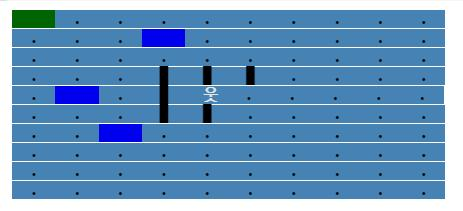

44

In [158]:
# @title Instantiate Environment
from IPython.display import Image
display(Image(filename='env.jpeg') )
env =  GridworldEnv()
env.reset()

In [136]:
# @title Hyperparams
total_episodes = 10000 #@param {type:"integer"}
max_step = 150 #@param {type:"integer"}
gamma = 0.95 #@param {type:"number"}
max_alpha = 0.99 #@param {type:"number"}
min_alpha = 0.0001 #@param {type:"number"}
max_epsilon =  0.99#@param {type:"number"}
min_epsilon = 0.0001 #@param {type:"number"}
decay_rate =  0.0005#@param {type:"number"}

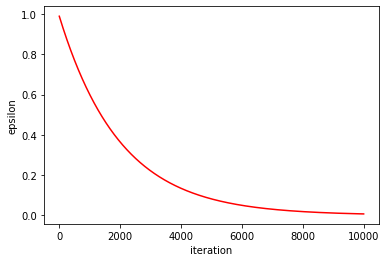

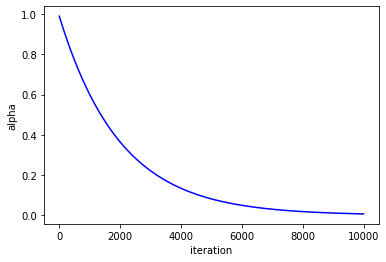

In [137]:
# @title Check decay rates
episodes = np.array(range(total_episodes))
plt.plot(episodes,
         min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episodes), color='red')
    
plt.xlabel("iteration")
plt.ylabel("epsilon")
plt.show()

episodes = np.array(range(total_episodes))
plt.plot(episodes,
         min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * episodes), color='blue')
    
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

In [138]:
# @title Epsilon Greedy Policy
def epsilon_greedy(epsilon, best_action):
  p = [epsilon / env.action_space.n] * env.action_space.n
  p[best_action] += (1-epsilon)
  return np.array(p)

In [139]:
# @title Episode Generation
def episode_generation(policy=None, Q=None, epsilon=None):
  episode = []
  state = env.reset()
  step = 0

  while step < max_step: # end of the episode
    if policy is None: # behave greedy
      p = epsilon_greedy(epsilon, np.argmax(Q))
    else:
      p = policy[state, :]
    action = np.random.choice(env.action_space.n, p=p)
    next_state, reward, done, info = env.step(action)
    episode.append((state, action, reward))
    
    state = next_state
    step += 1
    if reward == 10.0:
      break
  
  return episode, step

In [140]:
# @title Show Solution
def show_solution(Q):
  outfile = sys.stdout
  solution = np.argmax(Q, axis=1).reshape(10, 10)
  for i in range(solution.shape[0]):
    for j in range(solution.shape[1]):
      if solution[i, j] == 0:
        output = Fore.GREEN + " ↑ "
      elif solution[i, j] == 1:
        output = Fore.RED + " → "
      elif solution[i, j] == 2:
        output = Fore.BLACK + " ↓ "
      else:
        output = Fore.BLUE + " ← "
      outfile.write(output)
    outfile.write("\n")
    

In [141]:
# @title Plot Function
def plot(x, y, color, yscale, xlabel, ylabel, title, moving_avg=False, W=512):
  if moving_avg:
    y = np.convolve(y, np.ones(W), 'valid') / W
    x = x[:len(y)]
  plt.plot(x, y, color=color)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

## On-policy first-visit Monte Carlo

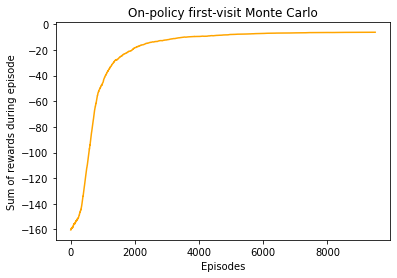

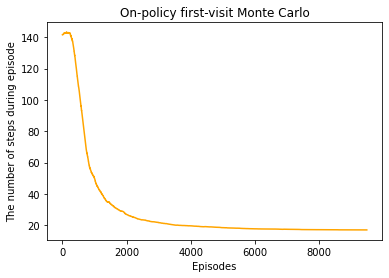

In [142]:
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
Q = np.zeros((env.observation_space.n, env.action_space.n))
returns = collections.defaultdict(float)
state_actions_count = collections.defaultdict(int)
on_policy_mc_episode_rewards = []
on_policy_mc_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)

  episode, episode_steps = episode_generation(policy=policy)
  G = 0

  state_actions = [(s, a) for (s, a, r) in episode]
  episode_reward = np.sum([r for (s, a, r) in episode])

  for t, (state, action, reward) in reversed(list(enumerate(episode))):
    G = gamma * G + reward
    if not (state, action) in state_actions[0:t]:
      returns[(state, action)] += G
      state_actions_count[(state, action)] += 1
      Q[state, action] = returns[(state, action)] / state_actions_count[(state, action)]

      A = np.argmax(Q[state], axis=0)
      for a in range(env.action_space.n):
        if a == A:
          policy[state, a] = 1 - epsilon + epsilon / env.action_space.n
        else:
          policy[state, a] = epsilon / env.action_space.n

  on_policy_mc_episode_rewards.append(episode_reward)
  on_policy_mc_episode_steps.append(episode_steps)


# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=on_policy_mc_episode_rewards, color="orange", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="On-policy first-visit Monte Carlo", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=on_policy_mc_episode_steps, color="orange", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="On-policy first-visit Monte Carlo", moving_avg=True)

In [143]:
show_solution(Q)

 ↑  ←  ←  ←  ←  ←  ←  ←  ←  ← 
 ↑  ←  ←  ←  ↑  →  ↑  ↑  ↑  ← 
 ↑  ←  ←  ←  ↑  ←  ↑  →  ↑  ← 
 ↑  ↑  ←  ↑  ↑  ↑  ↑  ↑  ↑  ← 
 ↑  ↑  ↑  ↑  →  →  →  →  ↑  ↑ 
 ↑  ←  ←  ↑  ↑  →  →  →  ↑  ↑ 
 ←  ↓  ↓  →  →  ↓  ↓  →  →  ↑ 
 ↓  ↓  ↓  ↓  →  ↓  →  ↑  →  ↑ 
 ↓  ↓  ↓  →  →  →  →  →  ↑  ↑ 
 →  ←  →  ↓  →  ↑  →  →  ↑  → 


## Off-policy Monte Carlo

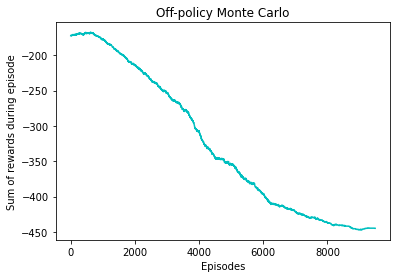

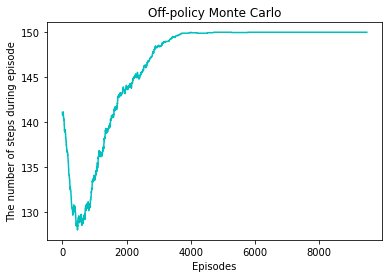

In [144]:
Q = np.zeros((env.observation_space.n, env.action_space.n))
C = np.zeros((env.observation_space.n, env.action_space.n))
off_policy_mc_episode_rewards = []
off_policy_mc_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)
  
  b = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
  # using epsilon policy based on Q 
  episode, episode_steps = episode_generation(policy=None, Q=Q, epsilon=epsilon) 
  # episode, episode_steps = episode_generation(policy=b) 
  G = 0
  W = 1

  episode_reward = np.sum([r for (s, a, r) in episode])

  for t, (state, action, reward) in reversed(list(enumerate(episode))):
    G = gamma * G + reward
    C[state, action] = C[state, action] + W
    Q[state, action] = Q[state, action] + (W / C[state, action]) * (G - Q[state, action])

    if action != np.argmax(Q[state]):
      break
    
    W = W * (1 / b[state, action])


  off_policy_mc_episode_rewards.append(episode_reward)
  off_policy_mc_episode_steps.append(episode_steps)


# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=off_policy_mc_episode_rewards, color="c", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="Off-policy Monte Carlo", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=off_policy_mc_episode_steps, color="c", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="Off-policy Monte Carlo", moving_avg=True)


In [145]:
show_solution(Q)

 ↑  ←  ←  ←  ←  ←  ←  →  ↓  ↓ 
 ↑  ←  ←  ←  →  →  ←  →  →  → 
 ↑  ←  ↑  ←  ←  ↑  ↓  →  ←  ↑ 
 ↑  ←  ←  ↑  ↑  ↑  ↑  →  ↑  ← 
 ↑  →  ↑  ↑  →  →  ←  ↓  ↓  → 
 ↑  ↑  →  ↑  ↑  ↓  ↑  ↑  →  ↑ 
 →  ↑  →  ↑  ←  ↓  ↑  ↑  ↑  ↑ 
 ↑  ↑  ↑  ↑  →  ↑  ↑  ↑  ↓  ↑ 
 ↑  ↑  →  ↑  →  ↓  →  ↑  ↑  ↑ 
 ↑  ↓  ↑  ↑  ↑  ↑  ↓  ↓  ↑  ↑ 


##Double Q-learning

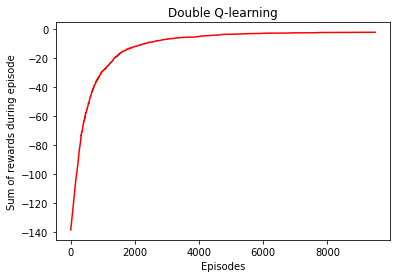

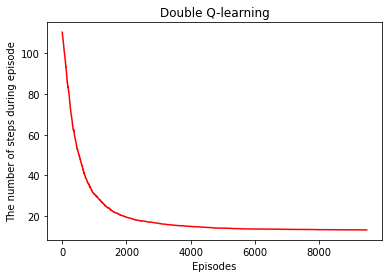

In [146]:
Q_1 = np.zeros((env.observation_space.n, env.action_space.n))
Q_2 = np.zeros((env.observation_space.n, env.action_space.n))
double_qlearning_episode_rewards = []
double_qlearning_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)
  state = env.reset()

  episode_reward = 0
  step = 0
  while step < max_step: # end of the episode
    
    action = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q_1[state] + Q_2[state])))
    next_state, reward, done, info = env.step(action)

    if np.random.uniform(0,1) < 0.5:
      G = reward + gamma * Q_2[next_state, np.argmax(Q_1[next_state], axis=0)]
      Q_1[state, action] = Q_1[state, action] + alpha * (G - Q_1[state, action])
    else:
      G = reward + gamma * Q_1[next_state, np.argmax(Q_2[next_state], axis=0)]
      Q_2[state, action] = Q_2[state, action] + alpha * (G - Q_2[state, action])

    state = next_state
    episode_reward += reward
    step += 1
    if reward == 10.0:
      break

  double_qlearning_episode_rewards.append(episode_reward)
  double_qlearning_episode_steps.append(step)


# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=double_qlearning_episode_rewards, color="r", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="Double Q-learning", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=double_qlearning_episode_steps, color="r", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="Double Q-learning", moving_avg=True)


In [147]:
show_solution(Q_1)

 ↑  ←  ←  ←  ←  ←  ←  ←  ←  ← 
 ↑  ↑  ↑  ←  ↑  ←  ←  ←  ↑  ↑ 
 ↑  ↑  ↑  ←  ↑  ←  ←  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ←  ←  ← 
 ↑  ↑  ↑  ↑  →  →  ↑  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ←  ←  ← 
 ↑  ←  ↑  →  →  ↑  ↑  ←  ↑  ↑ 
 ←  ←  ↑  ↑  ↑  ↑  ↑  ↑  ←  ↑ 
 ↑  ←  →  →  ↑  ↑  ↑  ↑  ↑  ↑ 
 ↑  →  ←  ↑  ↑  ↑  ↑  ←  ↑  ↑ 


In [148]:
show_solution(Q_2)

 ↑  ←  ←  ←  ←  ←  ←  ←  ←  ← 
 ↑  ↑  ↑  ←  ↑  ←  ←  ←  ↑  ← 
 ↑  ↑  ↑  ←  ↑  ←  ←  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ←  ←  ← 
 ↑  ↑  ↑  ↑  →  →  ↑  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ←  ←  ← 
 ↑  ←  ↑  →  →  ↑  ↑  ←  ←  ↑ 
 ↑  ←  ↑  ↑  ↑  ↑  ↑  ↑  ←  ↑ 
 ↑  ↑  ↑  →  ↑  ↑  ↑  ←  ←  ↑ 
 ↑  ↓  →  ↑  ↑  →  ↑  ↑  ←  ↑ 


## 2-Step Tree Back-up

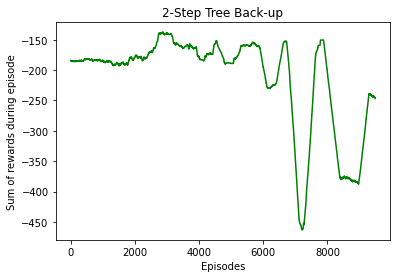

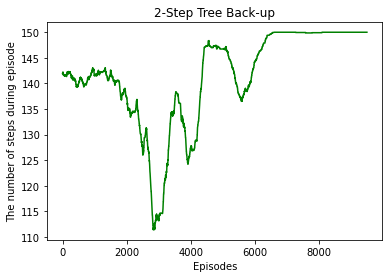

In [149]:
Q = np.zeros((env.observation_space.n, env.action_space.n))
two_step_tree_backup_episode_rewards = []
two_step_tree_backup_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)
  
  state = env.reset()
  action = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[state])))
  next_state_1, reward_1, done_1, info_1 = env.step(action)
  p=epsilon_greedy(epsilon, np.argmax(Q[next_state_1]))
  next_action_1 = np.random.choice(env.action_space.n, p=p)

  episode_reward = 0
  step = 0
  while step < max_step: # end of the episode

    next_state_2, reward_2, done_2, info_2 = env.step(next_action_1)
    next_action_2 = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[next_state_2])))

    p_1 = epsilon_greedy(epsilon, np.argmax(Q[next_state_1]))
    p_2 = epsilon_greedy(epsilon, np.argmax(Q[next_state_2]))

    G = reward_1 + gamma * np.sum(p_1[p_1 != next_action_1] * Q[next_state_1][p_1 != next_action_1]) + gamma * p_1[next_action_1] * (reward_2 + gamma * np.sum(p_2 * Q[next_state_2]))

    Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])

    
    state = next_state_1
    next_state_1 = next_state_2
    next_action_1 = next_action_2
    reward_1 = reward_2
    episode_reward += reward_2
    step += 1
    if reward_2 == 10.0:
      break

  two_step_tree_backup_episode_rewards.append(episode_reward)
  two_step_tree_backup_episode_steps.append(step)

# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=two_step_tree_backup_episode_rewards, color="g", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="2-Step Tree Back-up", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=two_step_tree_backup_episode_steps, color="g", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="2-Step Tree Back-up", moving_avg=True)


In [150]:
show_solution(Q)

 ↑  ←  ↑  ↑  ↑  ←  ↑  ↓  ←  ← 
 ↑  ↑  ↑  ↑  ↓  ←  ←  ←  ←  ↓ 
 ←  →  ↑  ↑  ←  ←  →  →  →  ↓ 
 ←  →  ↑  ↑  ↑  ↑  ↓  ↑  ↓  ↓ 
 ←  ↓  ↑  ↑  →  ↓  ←  ↓  ↓  ↓ 
 ↑  ↓  ↑  ↑  ↑  ←  ←  ↓  ↓  ↑ 
 ↓  ↓  ↓  ↓  ↓  ←  ↓  ←  ↓  ↓ 
 ↑  ←  ←  ↓  ←  ←  →  ←  ←  ↓ 
 ↓  ←  ↓  ↓  ↑  ←  ←  ←  ↑  ↓ 
 ↑  ↑  ↑  ↓  ↑  →  →  ↑  ↑  ↓ 


##SARSA

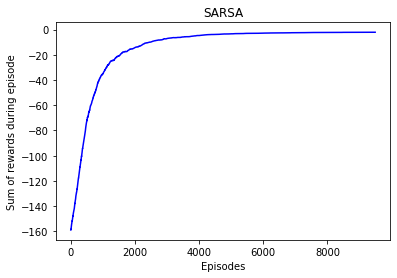

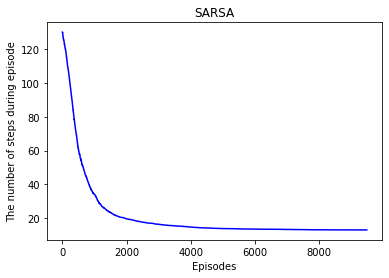

In [151]:
Q = np.zeros((env.observation_space.n, env.action_space.n))
v = np.zeros(env.observation_space.n)
sarsa_episode_rewards = []
sarsa_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)

  state = env.reset()
  action = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[state])))

  episode_reward = 0
  step = 0
  while step < max_step: # end of the episode
    
    next_state, reward, done, info = env.step(action)
    next_action = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[next_state])))

    G = reward + gamma * Q[next_state, next_action]
    Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])
    v[state]+=1

    state = next_state
    action = next_action
    episode_reward += reward
    step += 1
    if reward == 10.0:
      break

  sarsa_episode_rewards.append(episode_reward)
  sarsa_episode_steps.append(step)

# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=sarsa_episode_rewards, color="b", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="SARSA", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=sarsa_episode_steps, color="b", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="SARSA", moving_avg=True)


In [152]:
show_solution(Q)

 ←  ←  ←  ←  ←  ←  ←  ←  ←  ← 
 ↑  ↑  ←  ↑  ↑  ↑  ←  ←  ←  ← 
 ↑  ↑  ←  ←  ←  ←  ←  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ←  ←  ↑ 
 ↑  ↑  ↑  ↑  →  →  ↑  ←  ←  ← 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑ 
 ↑  ←  ←  →  →  ↑  ↑  ↑  ↑  ← 
 ↓  ↑  ↓  →  →  ↑  ↑  ↑  ↑  ↑ 
 →  ↓  ↓  →  →  ↑  ↑  ↑  ↑  ← 
 ←  ←  →  →  →  ↑  →  →  ↑  ↑ 


##2-Step Expected SARSA

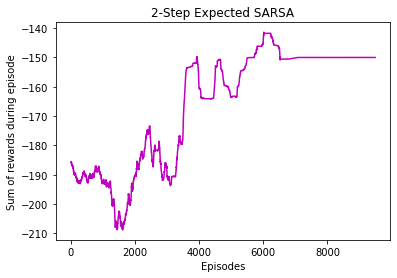

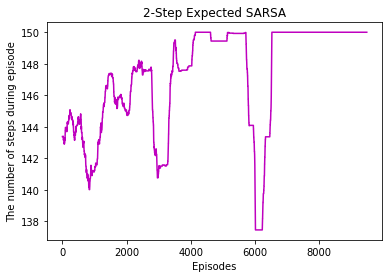

In [153]:
Q = np.zeros((env.observation_space.n, env.action_space.n))
two_step_expected_sarsa_episode_rewards = []
two_step_expected_sarsa_episode_steps = []

for iter in range(total_episodes):
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * iter) 
  alpha = min_alpha + (max_alpha - min_alpha) * np.exp(-decay_rate * iter)
  
  state = env.reset()
  action = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[state])))
  next_state_1, reward_1, done_1, info_1 = env.step(action)
  p=epsilon_greedy(epsilon, np.argmax(Q[next_state_1]))
  next_action_1 = np.random.choice(env.action_space.n, p=p)

  episode_reward = 0
  step = 0
  while step < max_step: # end of the episode

    next_state_2, reward_2, done_2, info_2 = env.step(next_action_1)
    next_action_2 = np.random.choice(env.action_space.n, p=epsilon_greedy(epsilon, np.argmax(Q[next_state_2])))

    p = epsilon_greedy(epsilon, np.argmax(Q[next_state_2]))
    G = reward_1 + gamma * reward_2 + np.square(gamma) * np.sum(p * Q[next_state_2, :])
    Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])

    state = next_state_1
    next_state_1 = next_state_2
    next_action_1 = next_action_2
    reward_1 = reward_2
    episode_reward += reward_2
    step += 1
    if reward_2 == 10.0:
      break

  two_step_expected_sarsa_episode_rewards.append(episode_reward)
  two_step_expected_sarsa_episode_steps.append(step)

# Plotting Sum of rewards during episode
plot(x=np.array(range(total_episodes)), y=two_step_expected_sarsa_episode_rewards, color="m", yscale="linear", xlabel="Episodes", ylabel="Sum of rewards during episode", title="2-Step Expected SARSA", moving_avg=True)
# Plotting the number of steps during episode
plot(x=np.array(range(total_episodes)), y=two_step_expected_sarsa_episode_steps, color="m", yscale="linear", xlabel="Episodes", ylabel="The number of steps during episode", title="2-Step Expected SARSA", moving_avg=True)


In [154]:
show_solution(Q)

 ↑  ↓  ←  →  ←  ←  ↓  ↑  ↑  ↑ 
 ↑  →  →  →  →  →  ←  →  ↑  ← 
 ↓  ↓  ←  →  →  →  →  ↓  ↓  ↓ 
 ↓  ←  ↓  ↑  ↑  ↑  →  ↓  ←  ← 
 ↓  ↑  ↓  ↑  →  →  ↓  ←  ←  ← 
 ↑  →  ↓  ↑  ↑  →  ↓  ↑  ↓  ← 
 →  →  →  →  ↑  →  →  →  ↓  ↓ 
 ←  ↑  ↓  ↓  ↑  →  →  →  →  ↓ 
 ←  ←  ←  →  →  →  →  ↓  ←  ↓ 
 →  →  →  →  →  →  ↓  ←  ↓  ↓ 


## Comparison

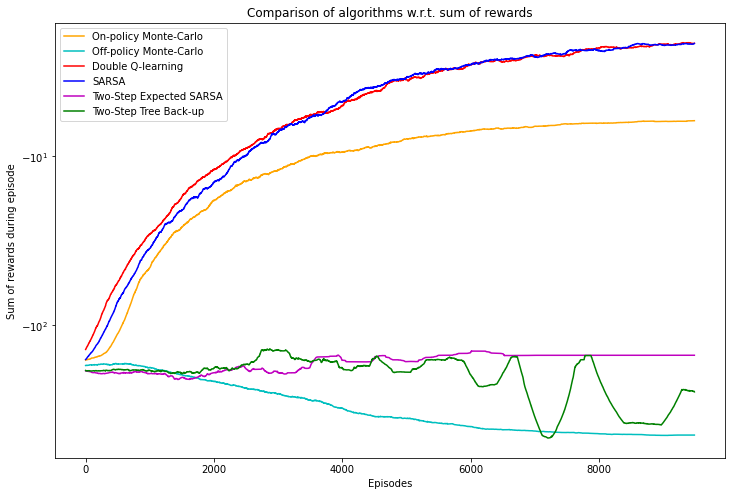

In [155]:
# @title Comparison of sum of reward
W = 512
episodes = np.array(range(total_episodes))
episodes = episodes[:len(episodes)-W+1]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(episodes, np.convolve(on_policy_mc_episode_rewards, np.ones(W), 'valid') / W, color="orange", label='On-policy Monte-Carlo')
ax.plot(episodes, np.convolve(off_policy_mc_episode_rewards, np.ones(W), 'valid') / W, color="c", label='Off-policy Monte-Carlo')
ax.plot(episodes, np.convolve(double_qlearning_episode_rewards, np.ones(W), 'valid') / W, color="r", label='Double Q-learning')
ax.plot(episodes, np.convolve(sarsa_episode_rewards, np.ones(W), 'valid') / W, color="b", label='SARSA')
ax.plot(episodes, np.convolve(two_step_expected_sarsa_episode_rewards, np.ones(W), 'valid') / W, color="m", label='Two-Step Expected SARSA')
ax.plot(episodes, np.convolve(two_step_tree_backup_episode_rewards, np.ones(W), 'valid') / W, color="g", label='Two-Step Tree Back-up')

legend = ax.legend()
plt.yscale("symlog")
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.title("Comparison of algorithms w.r.t. sum of rewards")
plt.show()

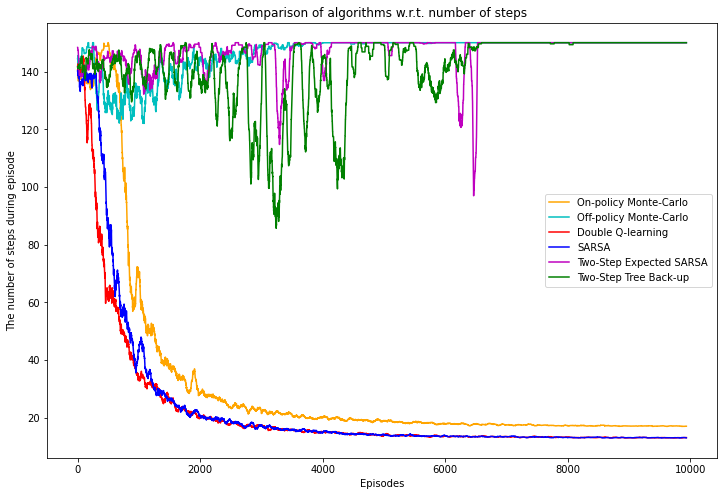

In [156]:
# @title Comparison of number of steps
W = 64
episodes = np.array(range(total_episodes))
episodes = episodes[:len(episodes)-W+1]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(episodes, np.convolve(on_policy_mc_episode_steps, np.ones(W), 'valid') / W, color="orange", label='On-policy Monte-Carlo')
ax.plot(episodes, np.convolve(off_policy_mc_episode_steps, np.ones(W), 'valid') / W, color="c", label='Off-policy Monte-Carlo')
ax.plot(episodes, np.convolve(double_qlearning_episode_steps, np.ones(W), 'valid') / W, color="r", label='Double Q-learning')
ax.plot(episodes, np.convolve(sarsa_episode_steps, np.ones(W), 'valid') / W, color="b", label='SARSA')
ax.plot(episodes, np.convolve(two_step_expected_sarsa_episode_steps, np.ones(W), 'valid') / W, color="m", label='Two-Step Expected SARSA')
ax.plot(episodes, np.convolve(two_step_tree_backup_episode_steps, np.ones(W), 'valid') / W, color="g", label='Two-Step Tree Back-up')

legend = ax.legend()
plt.xlabel("Episodes")
plt.ylabel("The number of steps during episode")
plt.title("Comparison of algorithms w.r.t. number of steps")
plt.show()